In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
pip install pyvi

In [71]:
import os
import numpy as np
import pandas as pd

from gensim.models import Word2Vec, Phrases
from gensim.models.fasttext import FastText
from pyvi import ViTokenizer
from gensim.models.phrases import Phrases, Phraser

In [72]:
pathdata = '/content/drive/MyDrive/Data full/merged_data (2).txt'
stopwords_path = '/content/drive/MyDrive/Data full/stopwords.csv'

model_path = '/content/drive/MyDrive/Data full/word2vec.model'

In [73]:
# Đọc dữ liệu từ file
train_data = pd.read_csv(pathdata, delimiter='\t', header=None, names=['text'])
train_data['text_tokenized'] = train_data['text'].apply(ViTokenizer.tokenize)
train_data

,text,text_tokenized
0,Việt Nam quốc hiệu là Cộng hòa Xã hội chủ ngh...,Việt_Nam quốc_hiệu là Cộng_hòa Xã_hội chủ_nghĩ...
1,Lãnh thổ Việt Nam xuất hiện con người sinh sốn...,Lãnh_thổ Việt_Nam xuất_hiện con_người sinh_sốn...
2,Đến thời kỳ cận đại Việt Nam lần lượt trải qu...,Đến thời_kỳ cận_đại Việt_Nam lần_lượt trải qua...
3,Sau khi thống nhất Việt Nam tiếp tục gặp khó ...,Sau khi thống_nhất Việt_Nam tiếp_tục gặp khó_k...
4,Tên gọi,Tên gọi
...,...,...
12232,Y học Gerhard Domagk,Y_học Gerhard_Domagk
12233,Văn học Frans Eemil Sillanpää,Văn_học Frans Eemil_Sillanpää
12234,Hòa bình không có giải,Hòa_bình không có giải
12235,Xem thêm,Xem thêm


In [74]:
# Đọc danh sách stopwords
stopwords_data = pd.read_csv(stopwords_path, sep="\t", encoding='utf-8')
stopwords_set = set(stopwords_data['stopwords'])
stopwords_data['stopwords'].head()

0      mà_thôi
1       tuy_có
2      đâu_như
3    quay_bước
4      hỏi_lại
Name: stopwords, dtype: object

In [75]:
# Tiền xử lý dữ liệu
train_data['text_cleaned'] = train_data['text_tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_set]))
train_data['text_cleaned']

0        Việt_Nam quốc_hiệu Cộng_hòa Xã_hội chủ_nghĩa V...
1        Lãnh_thổ Việt_Nam con_người sinh_sống thời_đại...
2        Đến thời_kỳ cận_đại Việt_Nam lần_lượt trải gia...
3        Sau thống_nhất Việt_Nam sụp_đổ tan_rã đồng_min...
4                                                  Tên gọi
                               ...                        
12232                                 Y_học Gerhard_Domagk
12233                        Văn_học Frans Eemil_Sillanpää
12234                                        Hòa_bình giải
12235                                                  Xem
12236                                            Tham_khảo
Name: text_cleaned, Length: 12237, dtype: object

In [76]:
# Chuyển dữ liệu huấn luyện thành danh sách các từ
sentences = [text.split() for text in train_data['text_cleaned']]

### Word2Vec Skip-gram

In [77]:
# Xử lý các cặp từ thông dụng hoặc cụm từ
bigram_transformer = Phraser(Phrases(sentences, min_count=5, threshold=100))
sentences_with_phrases = list(bigram_transformer[sentences])

# Xây dựng mô hình Word2Vec với Skip-gram
model_word2vec_skipgram = Word2Vec(sentences_with_phrases,
                                   vector_size=150,
                                   window=10,
                                   min_count=10,
                                   workers=4,
                                   sg=1,
                                   negative=5)
model_word2vec_skipgram.save(model_path)

In [78]:
# Lấy số lượng từ trong từ vựng
total_words_skipgram = len(model_word2vec_skipgram.wv.key_to_index)
total_words_skipgram

1499

In [79]:
model_size_skipgram = model_word2vec_skipgram.estimate_memory()
model_size_skipgram

{'vocab': 749500, 'vectors': 899400, 'syn1neg': 899400, 'total': 2548300}

In [80]:
# Hiển thị từ có độ tương đồng cao nhất
for word, score in model_word2vec_skipgram.wv.most_similar("Hồ_Chí_Minh"):
    print(word, score)

Hội 0.9686234593391418
Nguyễn_Ái_Quốc 0.9671538472175598
cách_mạng 0.9617722034454346
Cộng_sản 0.9567036032676697
chủ_nghĩa 0.947820246219635
thuộc_địa 0.9446837306022644
Quốc_tế 0.9440922141075134
dân_tộc 0.9430583119392395
Ông 0.9415310025215149
cộng_sản 0.9409571886062622


In [81]:
# Tính toán khoảng cách giữa hai từ
word1 = "máy_tính"
word2 = "Độc_lập"
distance = model_word2vec_skipgram.wv.distance(word1, word2)
print(f"Khoảng cách giữa '{word1}' và '{word2}': {distance}")

Khoảng cách giữa 'máy_tính' và 'Độc_lập': 0.18718558549880981


In [82]:
#Trích xuất vectơ word embedding của một từ
word = "máy_tính"
embedding_vector = model_word2vec_skipgram.wv.get_vector(word)
print(f"Vectơ word embedding của '{word}': {embedding_vector}")

Vectơ word embedding của 'máy_tính': [-0.02903945 -0.0745438  -0.0332404  -0.009096   -0.15900938 -0.05450469
 -0.0249979   0.18541136  0.0007604   0.12217595  0.04000765 -0.12199783
 -0.06824296  0.07345252 -0.02779063 -0.05421032  0.05587257 -0.16560638
 -0.05321585  0.02353144 -0.20040898 -0.04594284 -0.08841023 -0.05284441
  0.06602795  0.06189613 -0.20018347 -0.08629145 -0.04048357 -0.0891248
 -0.04493064  0.0935576   0.09149639 -0.10724458 -0.20265988  0.03730421
  0.1673609  -0.03449797  0.02111766 -0.13185182  0.02124136  0.09267955
 -0.09686408 -0.01525557  0.23042862  0.01064831 -0.06440387  0.00086138
  0.04052863  0.10338619 -0.05336395  0.02377466 -0.13269885  0.01209484
 -0.04157796  0.06690992 -0.07578155  0.10183786 -0.04960031 -0.01328503
 -0.07640398 -0.04654844 -0.07114676  0.08034169  0.04044465  0.07155436
 -0.06365417 -0.04867494 -0.15229236 -0.10040008  0.00334054  0.18142653
  0.09612696 -0.05566394 -0.0685341   0.06204519  0.00511177  0.05729675
 -0.01708317 -0

###Visualize Skip_gram


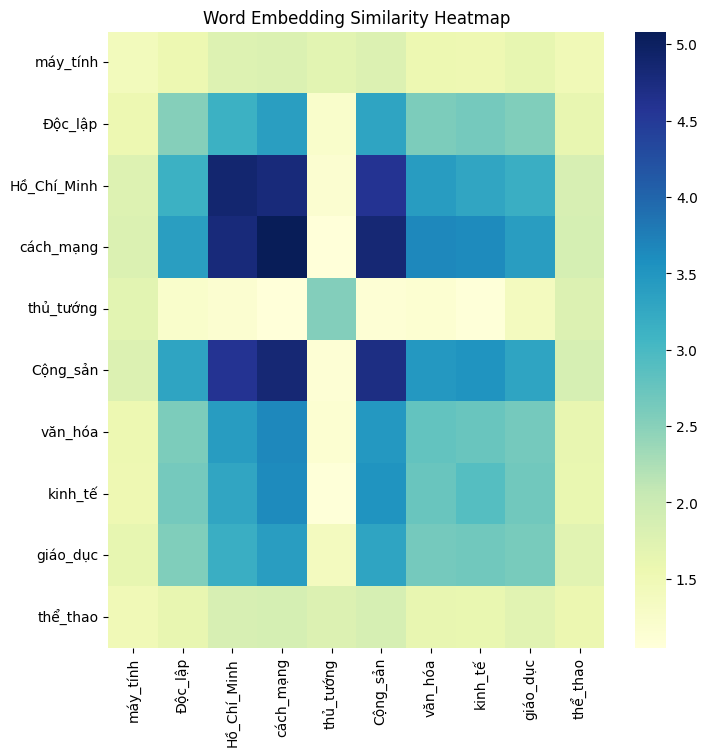

In [86]:
import seaborn as sns

# Chọn 10 từ để phân tích
selected_words = ["máy_tính", "Độc_lập", "Hồ_Chí_Minh", "cách_mạng", "thủ_tướng", "Cộng_sản", "văn_hóa", "kinh_tế", "giáo_dục", "thể_thao"]

# Lấy word vectors tương ứng với các từ
word_vectors = model_word2vec_skipgram.wv[selected_words]

# Tính ma trận tương đồng cosine giữa các từ
similarity_matrix = word_vectors @ word_vectors.T

# Trực quan hóa ma trận tương đồng cosine bằng heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(similarity_matrix, xticklabels=selected_words, yticklabels=selected_words, cmap="YlGnBu")

plt.title("Word Embedding Similarity Heatmap")
plt.show()

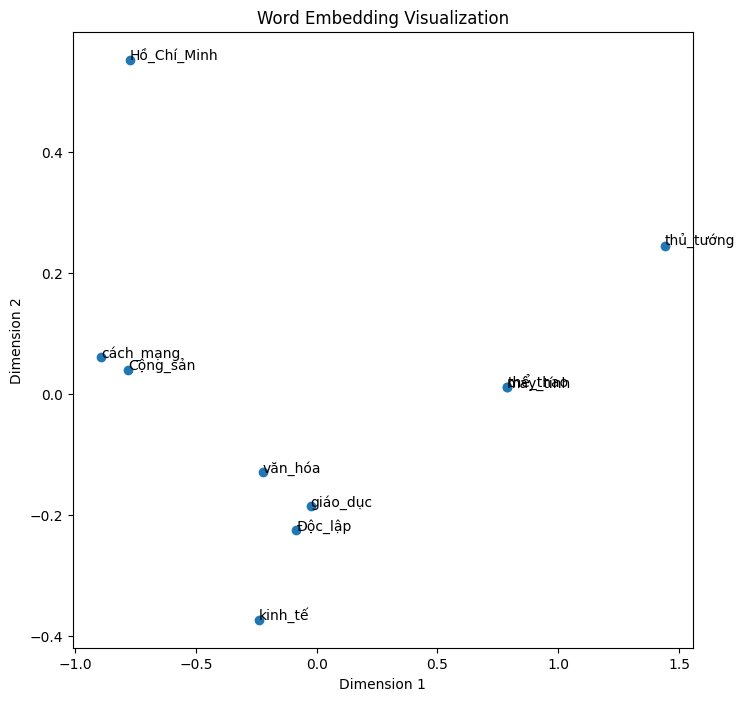

In [87]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Chọn 10 từ để phân tích
selected_words = ["máy_tính", "Độc_lập", "Hồ_Chí_Minh", "cách_mạng", "thủ_tướng", "Cộng_sản", "văn_hóa", "kinh_tế", "giáo_dục", "thể_thao"]

# Lấy word vectors tương ứng với các từ
word_vectors = model_word2vec_skipgram.wv[selected_words]

# Giảm chiều dữ liệu từ vector 150 chiều xuống còn 2 chiều
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Tạo đồ thị trực quan hóa
plt.figure(figsize=(8, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], marker='o')

# Hiển thị từng từ lên đồ thị
for i, word in enumerate(selected_words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Word Embedding Visualization")
plt.show()

### Word2Vec CBOW

In [88]:
# Xử lý các cặp từ thông dụng hoặc cụm từ
bigram_transformer = Phraser(Phrases(sentences, min_count=5, threshold=100))
sentences_with_phrases = list(bigram_transformer[sentences])

In [89]:
# Xây dựng mô hình Word2Vec với CBOW
model_word2vec_cbow = Word2Vec(sentences_with_phrases,
                               vector_size=150,
                               window=10,
                               min_count=10,
                               workers=4,
                               sg=0,
                               negative=5)
model_word2vec_cbow.save(model_path)

In [90]:
# Hiển thị từ có độ tương đồng cao nhất
for word, score in model_word2vec_cbow.wv.most_similar("Hồ_Chí_Minh"):
    print(word, score)

Việt_Nam 0.9993650317192078
Đảng 0.9986934065818787
tổ_chức 0.9978793859481812
miền_Nam 0.9977027773857117
dân_tộc 0.9975758194923401
Trung_Quốc 0.9973978400230408
chủ_nghĩa 0.9973875880241394
dân 0.9972832202911377
đi 0.9969354271888733
Sài_Gòn 0.9969282150268555


In [91]:
# Tính toán khoảng cách giữa hai từ
word1 = "máy_tính"
word2 = "Độc_lập"
distance = model_word2vec_cbow.wv.distance(word1, word2)
print(f"Khoảng cách giữa '{word1}' và '{word2}': {distance}")

Khoảng cách giữa 'máy_tính' và 'Độc_lập': 0.002714812755584717


In [92]:
# Tính toán khoảng cách giữa hai từ
word1 = "Nhân_dân"
word2 = "Hoa_hậu"
distance = model_word2vec_cbow.wv.distance(word1, word2)
print(f"Khoảng cách giữa '{word1}' và '{word2}': {distance}")

Khoảng cách giữa 'Nhân_dân' và 'Hoa_hậu': 0.001925051212310791


In [93]:
#Trích xuất vectơ word embedding của một từ
word = "máy_tính"
embedding_vector = model_word2vec_cbow.wv.get_vector(word)
print(f"Vectơ word embedding của '{word}': {embedding_vector}")

Vectơ word embedding của 'máy_tính': [ 7.54528567e-02 -2.90119927e-02 -5.02161495e-02  3.52377929e-02
 -2.53084432e-02 -5.16934283e-02  5.54730669e-02  1.04269452e-01
  3.34523171e-02  2.30080653e-02  1.14937671e-01 -9.97878760e-02
 -1.16721928e-01  5.04759252e-02 -8.10886100e-02 -1.75115056e-02
  9.99418721e-02 -1.06155731e-01 -1.38115427e-02  4.92070951e-02
 -1.13183886e-01 -6.58340976e-02  3.71062420e-02 -6.15638942e-02
  8.36598873e-02  2.97186449e-02 -2.13381693e-01 -9.68913063e-02
  6.38089925e-02 -3.02310474e-02  7.92673081e-02  9.91811231e-02
 -5.02126627e-02 -1.38798784e-02 -1.04895778e-01  6.02238029e-02
  1.05911009e-01 -4.19047847e-03  7.02822804e-02 -3.18656825e-02
 -4.28698212e-03  7.14310119e-03 -5.71533367e-02 -4.25545089e-02
  7.77358934e-02  1.49219157e-02  6.05509020e-02  7.69382641e-02
 -1.42129138e-02  7.45375901e-02 -1.50740873e-02 -2.92134210e-02
 -9.43305120e-02  8.17871317e-02  1.07090185e-04  7.94438571e-02
 -2.21693404e-02  6.23360276e-02 -6.26694337e-02  4.2

###Visualize CBOW


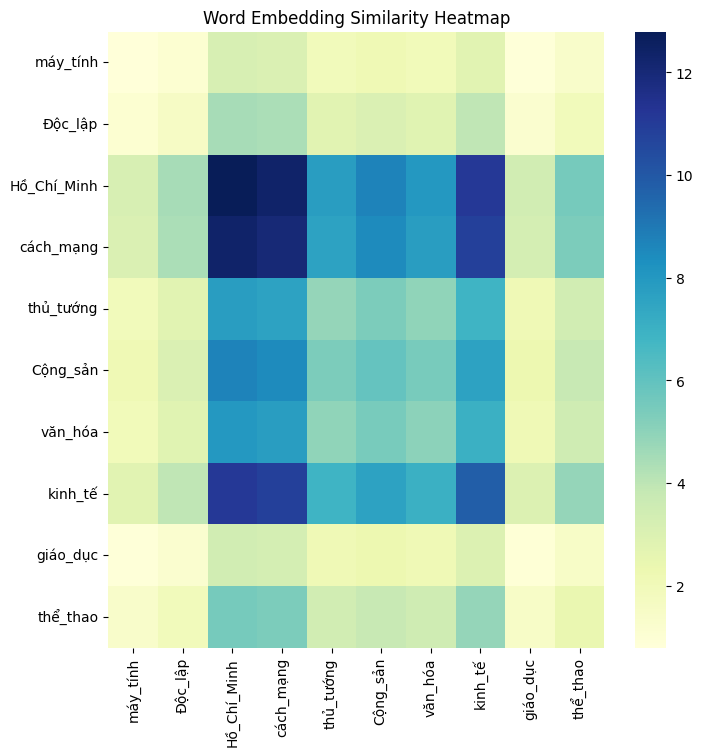

In [95]:
import seaborn as sns

# Chọn 10 từ để phân tích
selected_words = ["máy_tính", "Độc_lập", "Hồ_Chí_Minh", "cách_mạng", "thủ_tướng", "Cộng_sản", "văn_hóa", "kinh_tế", "giáo_dục", "thể_thao"]

# Lấy word vectors tương ứng với các từ
word_vectors = model_word2vec_cbow.wv[selected_words]

# Tính ma trận tương đồng cosine giữa các từ
similarity_matrix = word_vectors @ word_vectors.T

# Trực quan hóa ma trận tương đồng cosine bằng heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(similarity_matrix, xticklabels=selected_words, yticklabels=selected_words, cmap="YlGnBu")

plt.title("Word Embedding Similarity Heatmap")
plt.show()

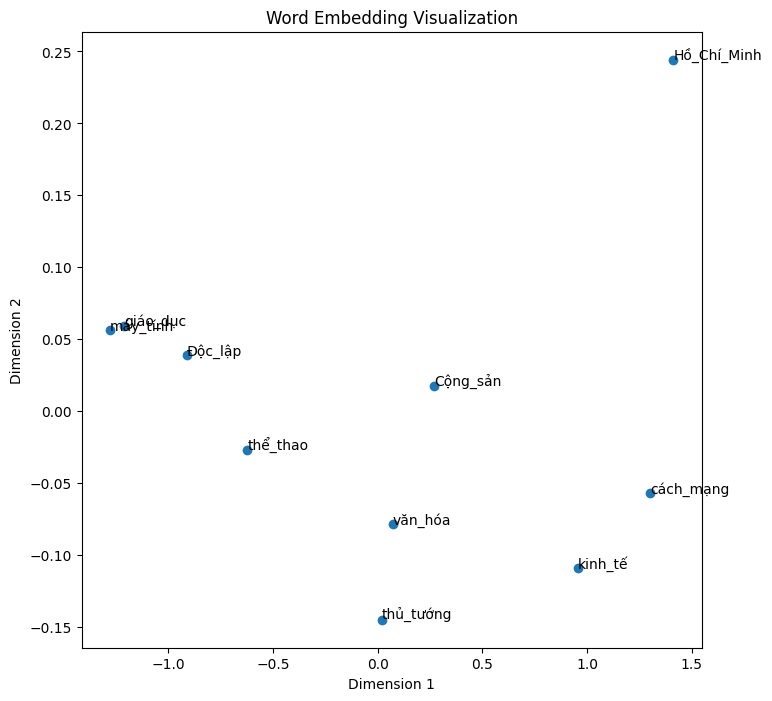

In [97]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Chọn 10 từ để phân tích
selected_words = ["máy_tính", "Độc_lập", "Hồ_Chí_Minh", "cách_mạng", "thủ_tướng", "Cộng_sản", "văn_hóa", "kinh_tế", "giáo_dục", "thể_thao"]

# Lấy word vectors tương ứng với các từ
word_vectors = model_word2vec_cbow.wv[selected_words]

# Giảm chiều dữ liệu từ vector 150 chiều xuống còn 2 chiều
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Tạo đồ thị trực quan hóa
plt.figure(figsize=(8, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], marker='o')

# Hiển thị từng từ lên đồ thị
for i, word in enumerate(selected_words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Word Embedding Visualization")
plt.show()